<a href="https://colab.research.google.com/github/Bharat0207/Hospital_Admission_Analysis/blob/main/Patientreadmissionanalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import io

# Step 1: Upload the CSV file from your local computer
uploaded = files.upload()

# Step 2: Load the CSV into a Pandas DataFrame
df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))

# Step 3: Preview the first few rows
print(df.head())

# Step 4: Check dataset info (columns, data types, missing values)
print(df.info())

# Step 5: Check missing values per column
print(df.isnull().sum())

Saving hospital_readmissions.csv to hospital_readmissions.csv
       age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0  [70-80)                 8                72             1             18   
1  [70-80)                 3                34             2             13   
2  [50-60)                 5                45             0             18   
3  [70-80)                 2                36             0             12   
4  [60-70)                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

      

In [ ]:
import pandas as pd

# -----------------------------
# Step 2: Data Cleaning & Transformation (ETL)
# -----------------------------

# 1. Remove duplicate patient entries if patient_id exists
if 'patient_id' in df.columns:
    df = df.drop_duplicates(subset='patient_id')

# 2. Normalize column names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

# 3. Handle missing values
# Fill numeric columns with median
numeric_cols = df.select_dtypes(include=['int64','float64']).columns
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with mode or 'Unknown'
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

# 4. Standardize department names (example)
if 'department' in df.columns:
    df['department'] = df['department'].replace({'Cardio':'Cardiology', 'Neph':'Nephrology'})

# 5. Clean and convert age column to numeric
if 'age' in df.columns:
    df['age'] = df['age'].astype(str).str.extract('(\d+)')  # Keep only digits
    df['age'] = pd.to_numeric(df['age'], errors='coerce')   # Convert to numeric
    df['age'] = df['age'].fillna(df['age'].median())        # Fill missing with median

    # Create age groups
    bins = [0,18,35,60,120]
    labels = ['0-18','19-35','36-60','60+']
    df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# 6. Count previous admissions per patient
if 'admission_id' in df.columns and 'patient_id' in df.columns:
    df['prev_admissions'] = df.groupby('patient_id')['admission_id'].transform('count') - 1

# -----------------------------
# Preview cleaned data
# -----------------------------
print(df.head())
print(df.info())
print(df.isnull().sum())


   age  time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0   70                 8                72             1             18   
1   70                 3                34             2             13   
2   50                 5                45             0             18   
3   70                 2                36             0             12   
4   60                 1                42             0              7   

   n_outpatient  n_inpatient  n_emergency medical_specialty       diag_1  \
0             2            0            0           Missing  Circulatory   
1             0            0            0             Other        Other   
2             0            0            0           Missing  Circulatory   
3             1            0            0           Missing  Circulatory   
4             0            0            0  InternalMedicine        Other   

        diag_2       diag_3 glucose_test a1ctest change diabetes_med  \
0  Respiratory      

<>:31: SyntaxWarning: invalid escape sequence '\d'
<>:31: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3134893345.py:31: SyntaxWarning: invalid escape sequence '\d'
  df['age'] = df['age'].astype(str).str.extract('(\d+)')  # Keep only digits


EDA

Readmission Counts:
 readmitted
no     13246
yes    11754
Name: count, dtype: int64

Readmission Percent:
 readmitted
no     52.984
yes    47.016
Name: proportion, dtype: float64


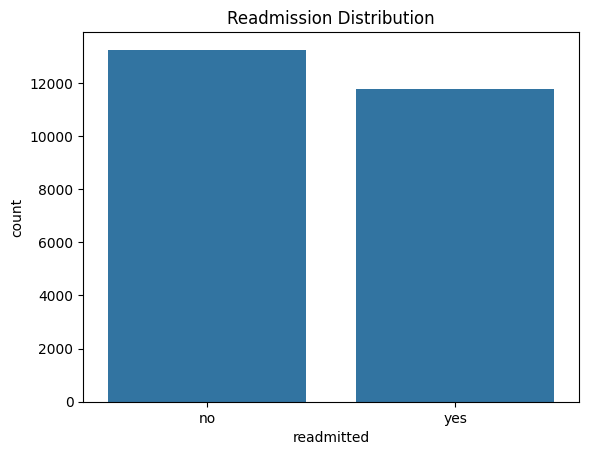

In [ ]:
readmission_counts = df['readmitted'].value_counts()
readmission_percent = df['readmitted'].value_counts(normalize=True) * 100

print("Readmission Counts:\n", readmission_counts)
print("\nReadmission Percent:\n", readmission_percent)

import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='readmitted', data=df)
plt.title("Readmission Distribution")
plt.show()

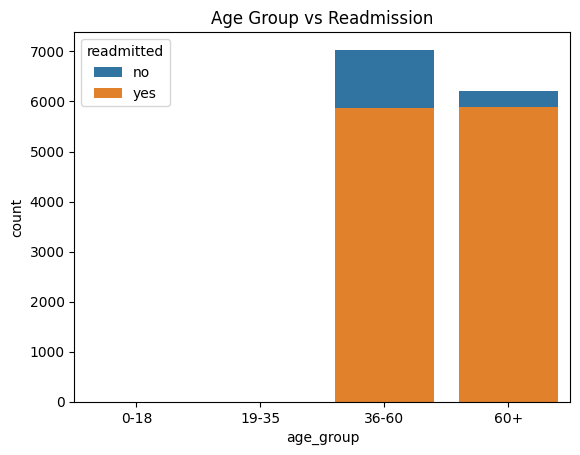

In [ ]:
sns.countplot(x='age_group', hue='readmitted', data=df)
plt.title("Age Group vs Readmission")
plt.show()

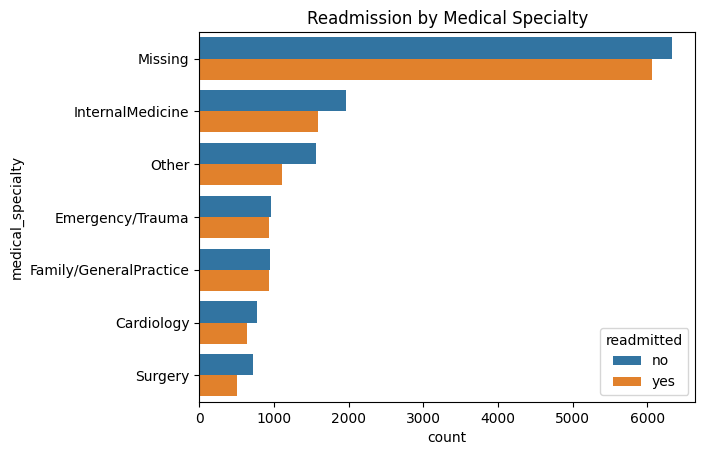

In [ ]:
sns.countplot(y='medical_specialty', hue='readmitted', data=df, order=df['medical_specialty'].value_counts().index)
plt.title("Readmission by Medical Specialty")
plt.show()

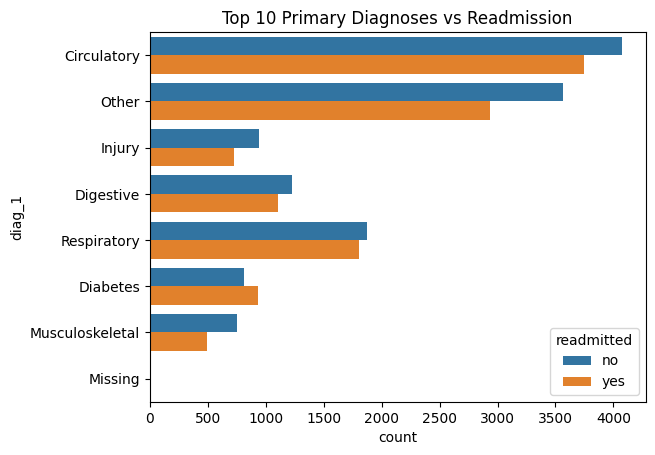

In [ ]:
top_diag1 = df['diag_1'].value_counts().index[:10]  # top 10 diagnoses
sns.countplot(y='diag_1', hue='readmitted', data=df[df['diag_1'].isin(top_diag1)])
plt.title("Top 10 Primary Diagnoses vs Readmission")
plt.show()

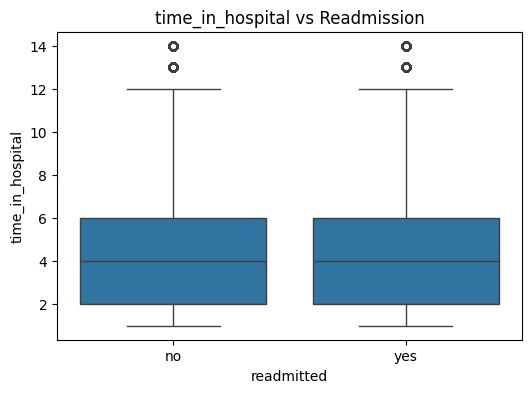

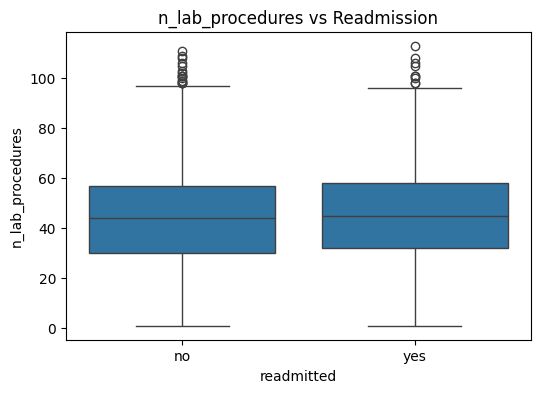

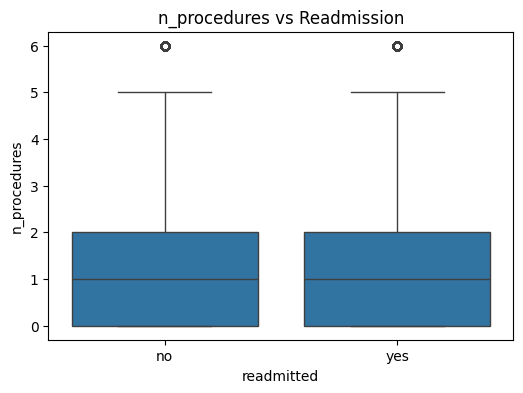

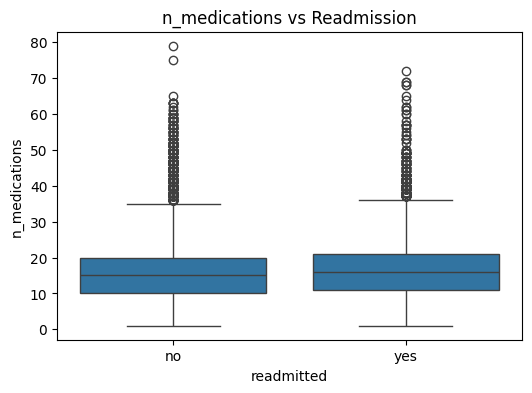

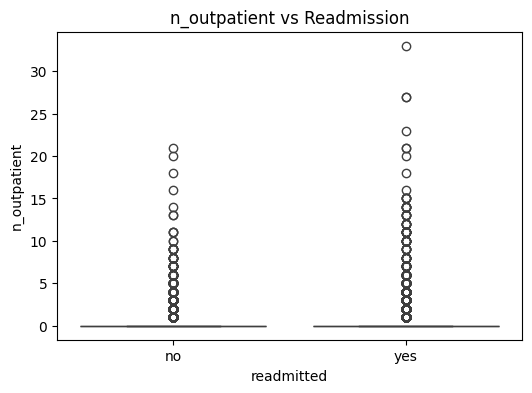

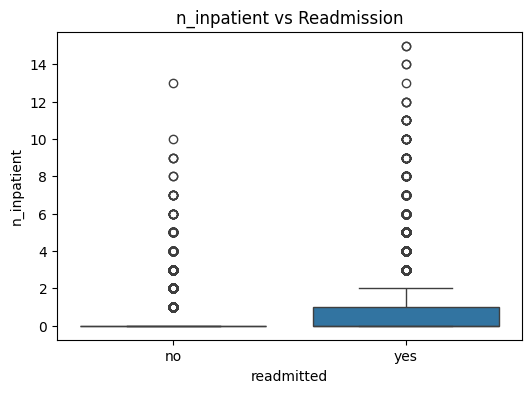

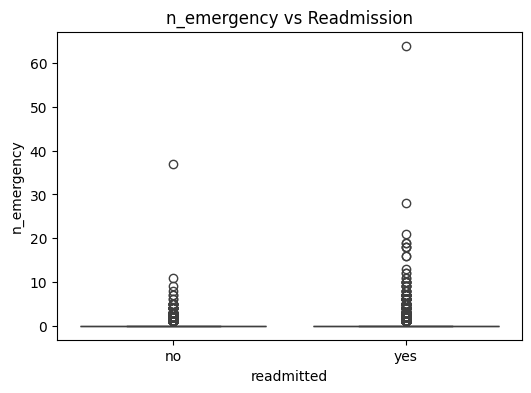

In [ ]:
numeric_cols = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='readmitted', y=col, data=df)
    plt.title(f"{col} vs Readmission")
    plt.show()

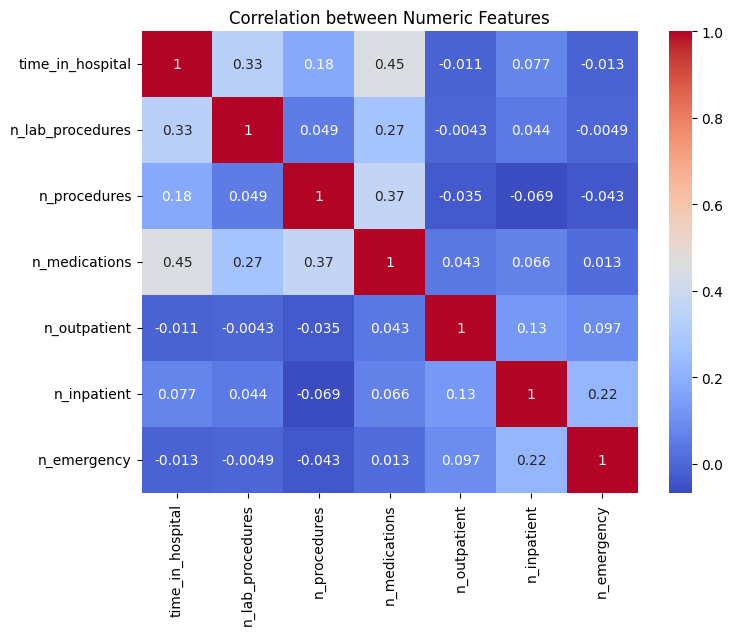

In [ ]:
corr = df[numeric_cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation between Numeric Features")
plt.show()

Risk & Pattern Analysis

readmitted  readmitted_rate
age_group                  
0-18               0.000000
19-35              0.000000
36-60             45.460185
60+               48.673883


/tmp/ipython-input-1121791054.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_risk = df.groupby('age_group')['readmitted'].value_counts(normalize=True).unstack()


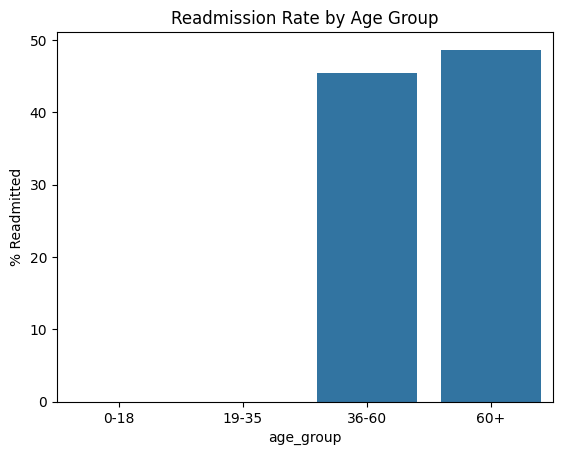

In [ ]:
age_risk = df.groupby('age_group')['readmitted'].value_counts(normalize=True).unstack()
age_risk['readmitted_rate'] = age_risk['yes'] * 100
print(age_risk[['readmitted_rate']])

# Visualize
sns.barplot(x=age_risk.index, y=age_risk['readmitted_rate'])
plt.title("Readmission Rate by Age Group")
plt.ylabel("% Readmitted")
plt.show()

readmitted              readmitted_rate
medical_specialty                      
Family/GeneralPractice        49.521785
Emergency/Trauma              49.389920
Missing                       48.909708
Cardiology                    44.996451
InternalMedicine              44.768583
Other                         41.478979
Surgery                       41.220115


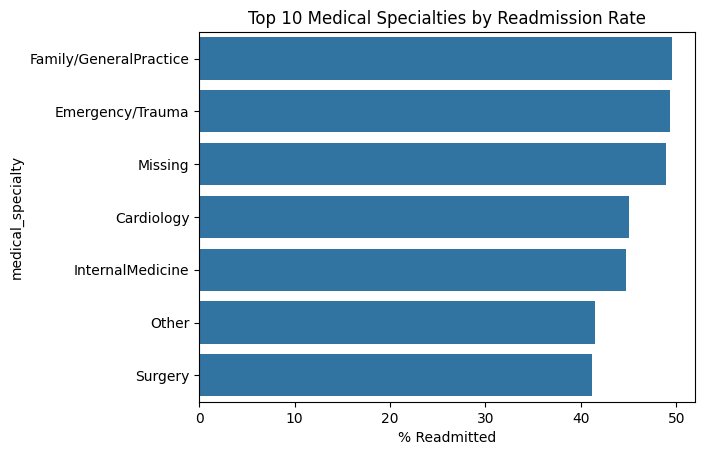

In [ ]:
dept_risk = df.groupby('medical_specialty')['readmitted'].value_counts(normalize=True).unstack()
dept_risk['readmitted_rate'] = dept_risk['yes'] * 100
dept_risk = dept_risk.sort_values(by='readmitted_rate', ascending=False)
print(dept_risk[['readmitted_rate']].head(10))

# Visualize top 10 specialties
sns.barplot(x='readmitted_rate', y=dept_risk.index[:10], data=dept_risk)
plt.title("Top 10 Medical Specialties by Readmission Rate")
plt.xlabel("% Readmitted")
plt.show()


readmitted       readmitted_rate
diag_1                          
Diabetes               53.634803
Missing                50.000000
Respiratory            49.076087
Circulatory            47.929448
Digestive              47.445255
Other                  45.121576
Injury                 43.637455
Musculoskeletal        39.536741


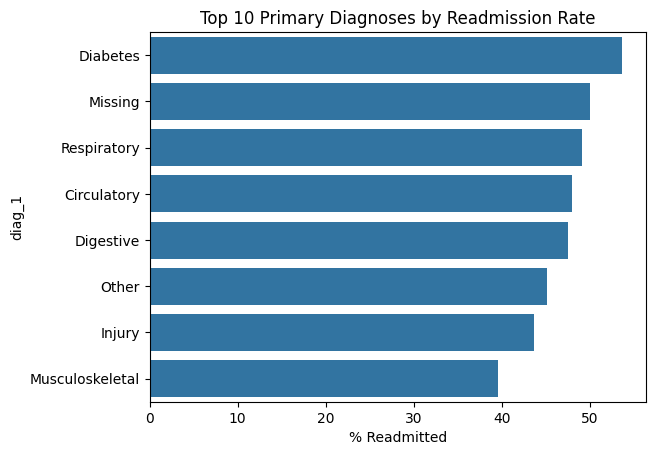

In [ ]:
diag_risk = df.groupby('diag_1')['readmitted'].value_counts(normalize=True).unstack()
diag_risk['readmitted_rate'] = diag_risk['yes'] * 100
diag_risk = diag_risk.sort_values(by='readmitted_rate', ascending=False)
print(diag_risk[['readmitted_rate']].head(10))

# Visualize
sns.barplot(x='readmitted_rate', y=diag_risk.index[:10], data=diag_risk)
plt.title("Top 10 Primary Diagnoses by Readmission Rate")
plt.xlabel("% Readmitted")
plt.show()

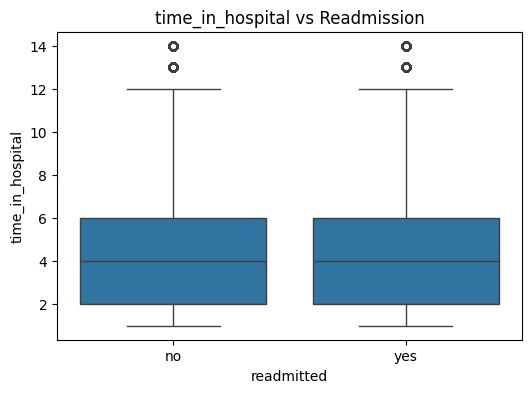

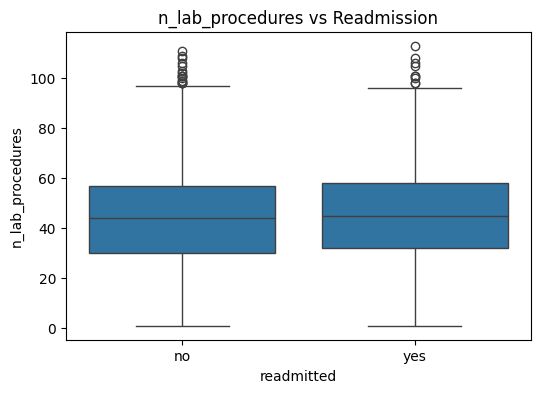

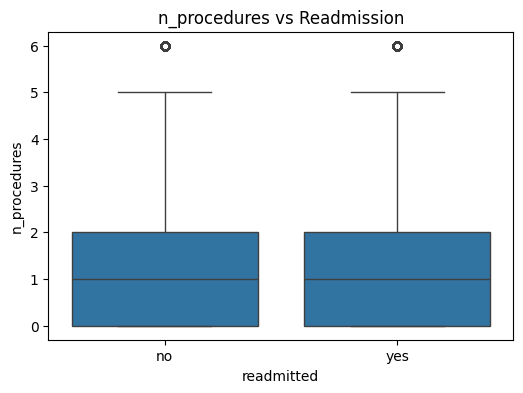

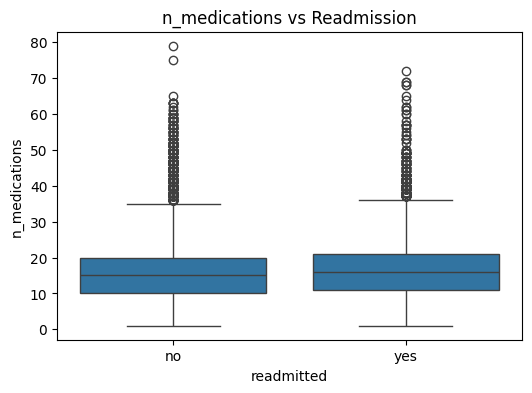

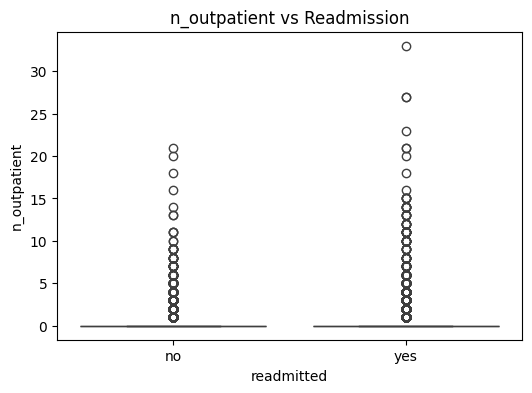

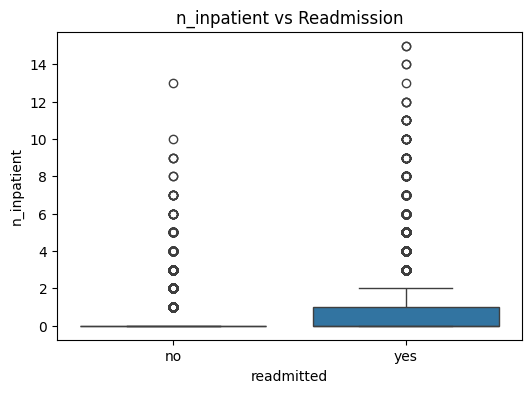

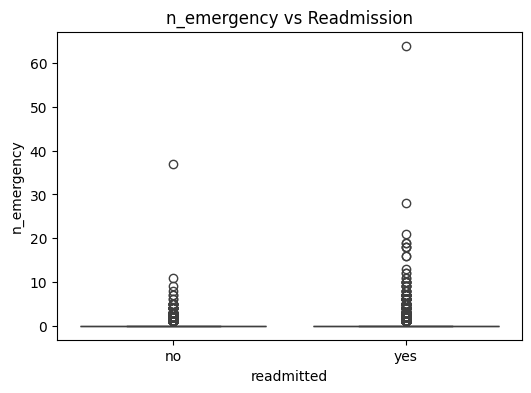

In [ ]:
numeric_cols = ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']

for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='readmitted', y=col, data=df)
    plt.title(f"{col} vs Readmission")
    plt.show()

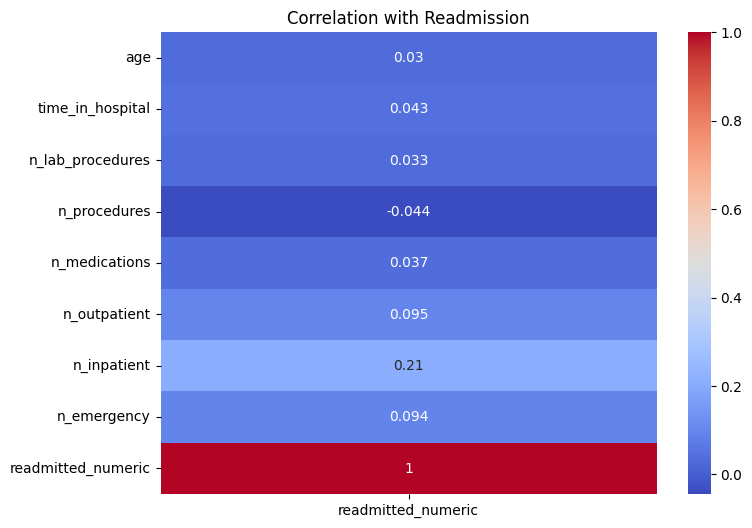

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Map readmitted to numeric
df['readmitted_numeric'] = df['readmitted'].map({'no':0, 'yes':1})

# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Compute correlation
corr = numeric_df.corr()

# Plot correlation with readmission
plt.figure(figsize=(8,6))
sns.heatmap(corr[['readmitted_numeric']], annot=True, cmap='coolwarm')
plt.title("Correlation with Readmission")
plt.show()


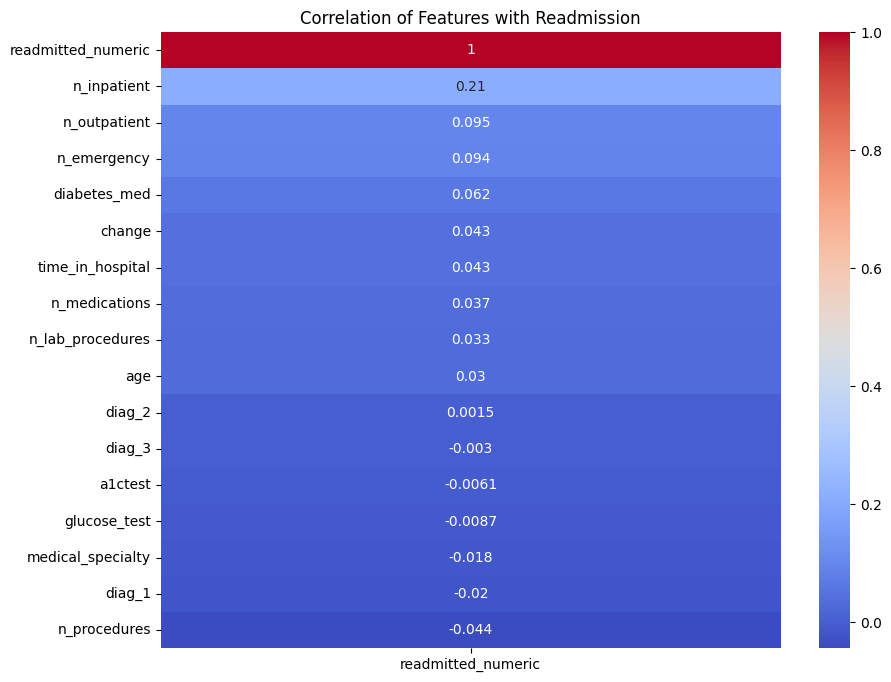

In [ ]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Map readmitted to numeric
df['readmitted_numeric'] = df['readmitted'].map({'no':0, 'yes':1})

# Copy dataframe to encode categorical columns
df_encoded = df.copy()

# Encode all categorical/object columns except 'readmitted' itself
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
categorical_cols = [col for col in categorical_cols if col != 'readmitted']

le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Now select all numeric columns
numeric_df = df_encoded.select_dtypes(include=['int64', 'float64'])

# Compute correlation
corr = numeric_df.corr()

# Plot correlation heatmap with readmission
plt.figure(figsize=(10,8))
sns.heatmap(corr[['readmitted_numeric']].sort_values(by='readmitted_numeric', ascending=False), annot=True, cmap='coolwarm')
plt.title("Correlation of Features with Readmission")
plt.show()

Visualization & Dashboarding

In [ ]:
total_patients = df.shape[0]
total_readmitted = df['readmitted'].value_counts()['yes']
readmission_rate = total_readmitted / total_patients * 100
avg_time_in_hospital = df['time_in_hospital'].mean()

print(f"Total Patients: {total_patients}")
print(f"Total Readmitted: {total_readmitted}")
print(f"Readmission Rate: {readmission_rate:.2f}%")
print(f"Average Time in Hospital: {avg_time_in_hospital:.2f} days")

Total Patients: 25000
Total Readmitted: 11754
Readmission Rate: 47.02%
Average Time in Hospital: 4.45 days


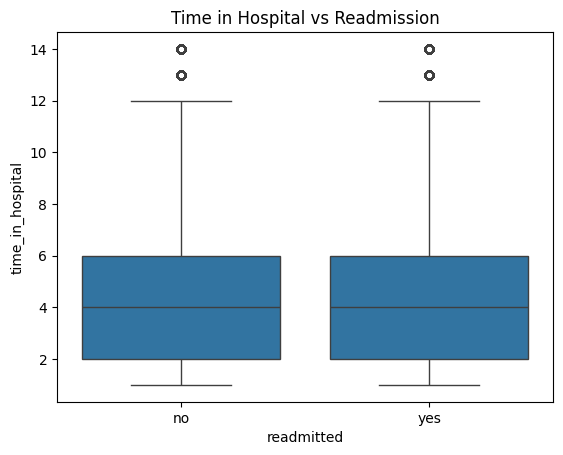

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x='readmitted', y='time_in_hospital', data=df)
plt.title("Time in Hospital vs Readmission")
plt.show()

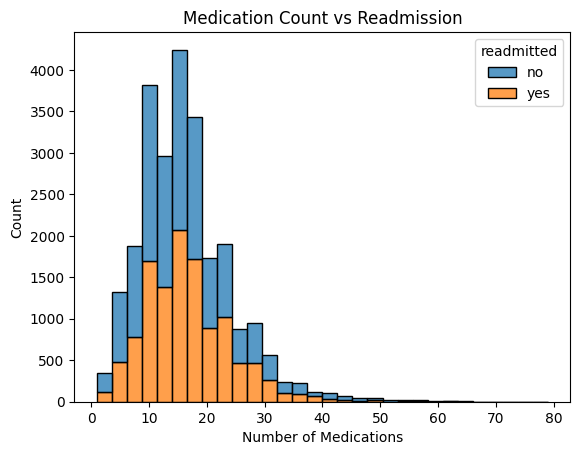

In [ ]:
sns.histplot(data=df, x='n_medications', hue='readmitted', multiple='stack', bins=30)
plt.title("Medication Count vs Readmission")
plt.xlabel("Number of Medications")
plt.show()

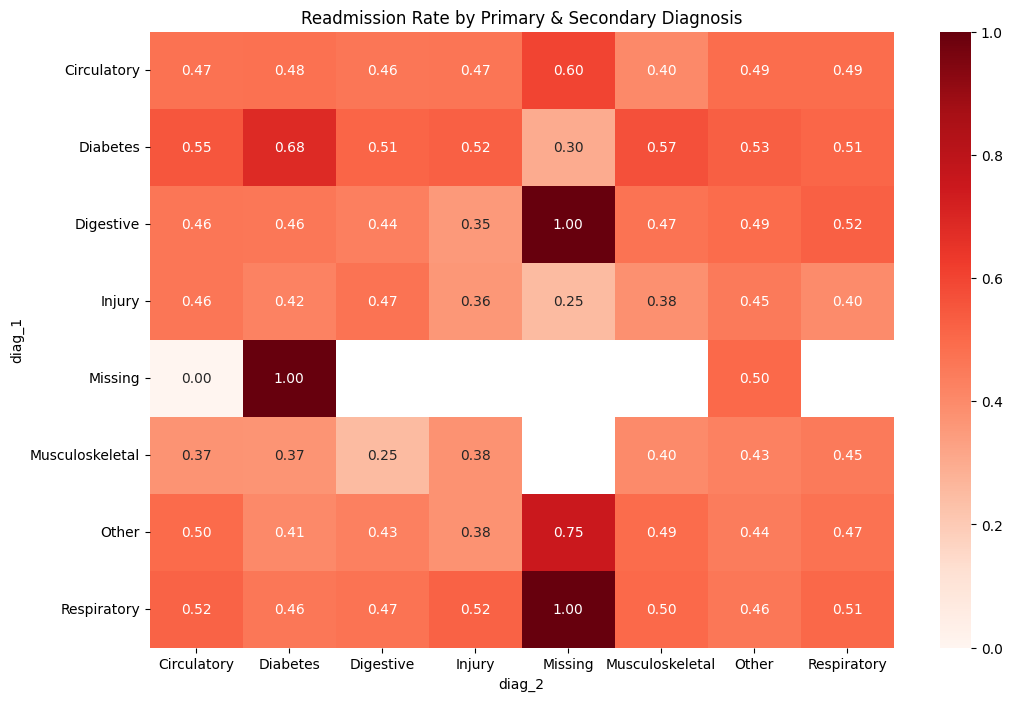

In [ ]:
df['readmitted_numeric'] = df['readmitted'].map({'no':0, 'yes':1})
diag_combo = df.groupby(['diag_1', 'diag_2'])['readmitted_numeric'].mean().reset_index()
diag_pivot = diag_combo.pivot(index='diag_1', columns='diag_2', values='readmitted_numeric')

plt.figure(figsize=(12,8))
sns.heatmap(diag_pivot, annot=True, fmt=".2f", cmap='Reds')
plt.title("Readmission Rate by Primary & Secondary Diagnosis")
plt.show()

In [ ]:
risk_factors = df[['age_group', 'medical_specialty', 'diag_1', 'time_in_hospital', 'n_medications', 'readmitted']]
high_risk_patients = risk_factors[risk_factors['readmitted']=='yes'].sort_values(by='time_in_hospital', ascending=False).head(10)
print(high_risk_patients)

      age_group       medical_specialty           diag_1  time_in_hospital  \
24995       60+                 Missing      Circulatory                14   
10148     36-60                   Other            Other                14   
788       36-60                 Missing         Diabetes                14   
23636     36-60        Emergency/Trauma      Respiratory                14   
9998      36-60                 Missing        Digestive                14   
23555     36-60  Family/GeneralPractice      Circulatory                14   
22640     36-60                 Missing            Other                14   
597         60+                 Missing  Musculoskeletal                14   
22521     36-60                 Missing      Circulatory                14   
22469     36-60        InternalMedicine      Circulatory                14   

       n_medications readmitted  
24995             30        yes  
10148             25        yes  
788               50        yes  
23636

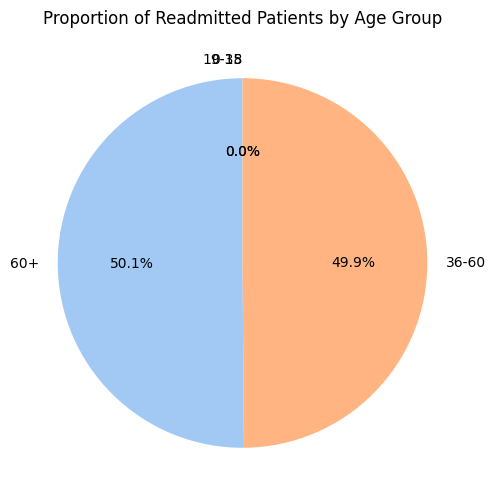

In [ ]:
age_readmit = df[df['readmitted']=='yes']['age_group'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(age_readmit, labels=age_readmit.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Proportion of Readmitted Patients by Age Group")
plt.show()

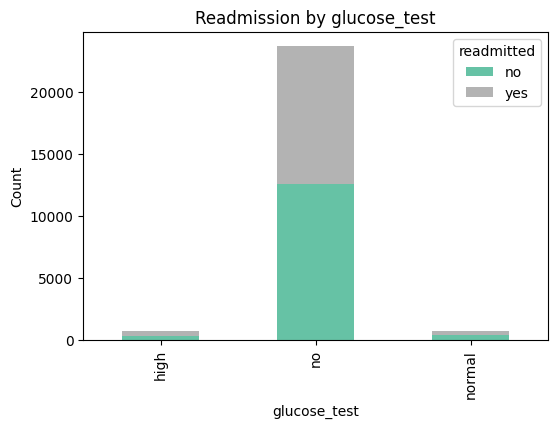

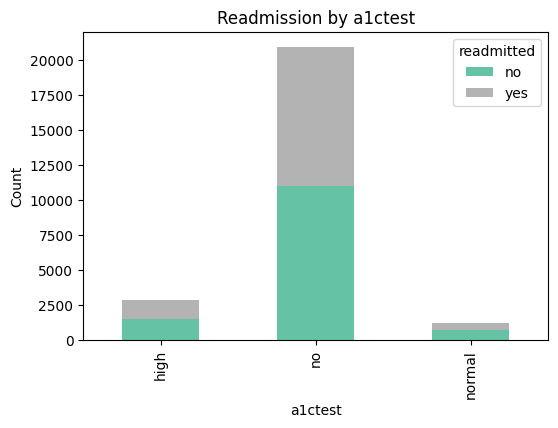

In [ ]:
test_cols = ['glucose_test', 'a1ctest']
for col in test_cols:
    test_risk = df.groupby([col, 'readmitted']).size().unstack()
    test_risk.plot(kind='bar', stacked=True, figsize=(6,4), colormap='Set2')
    plt.title(f"Readmission by {col}")
    plt.ylabel("Count")
    plt.show()

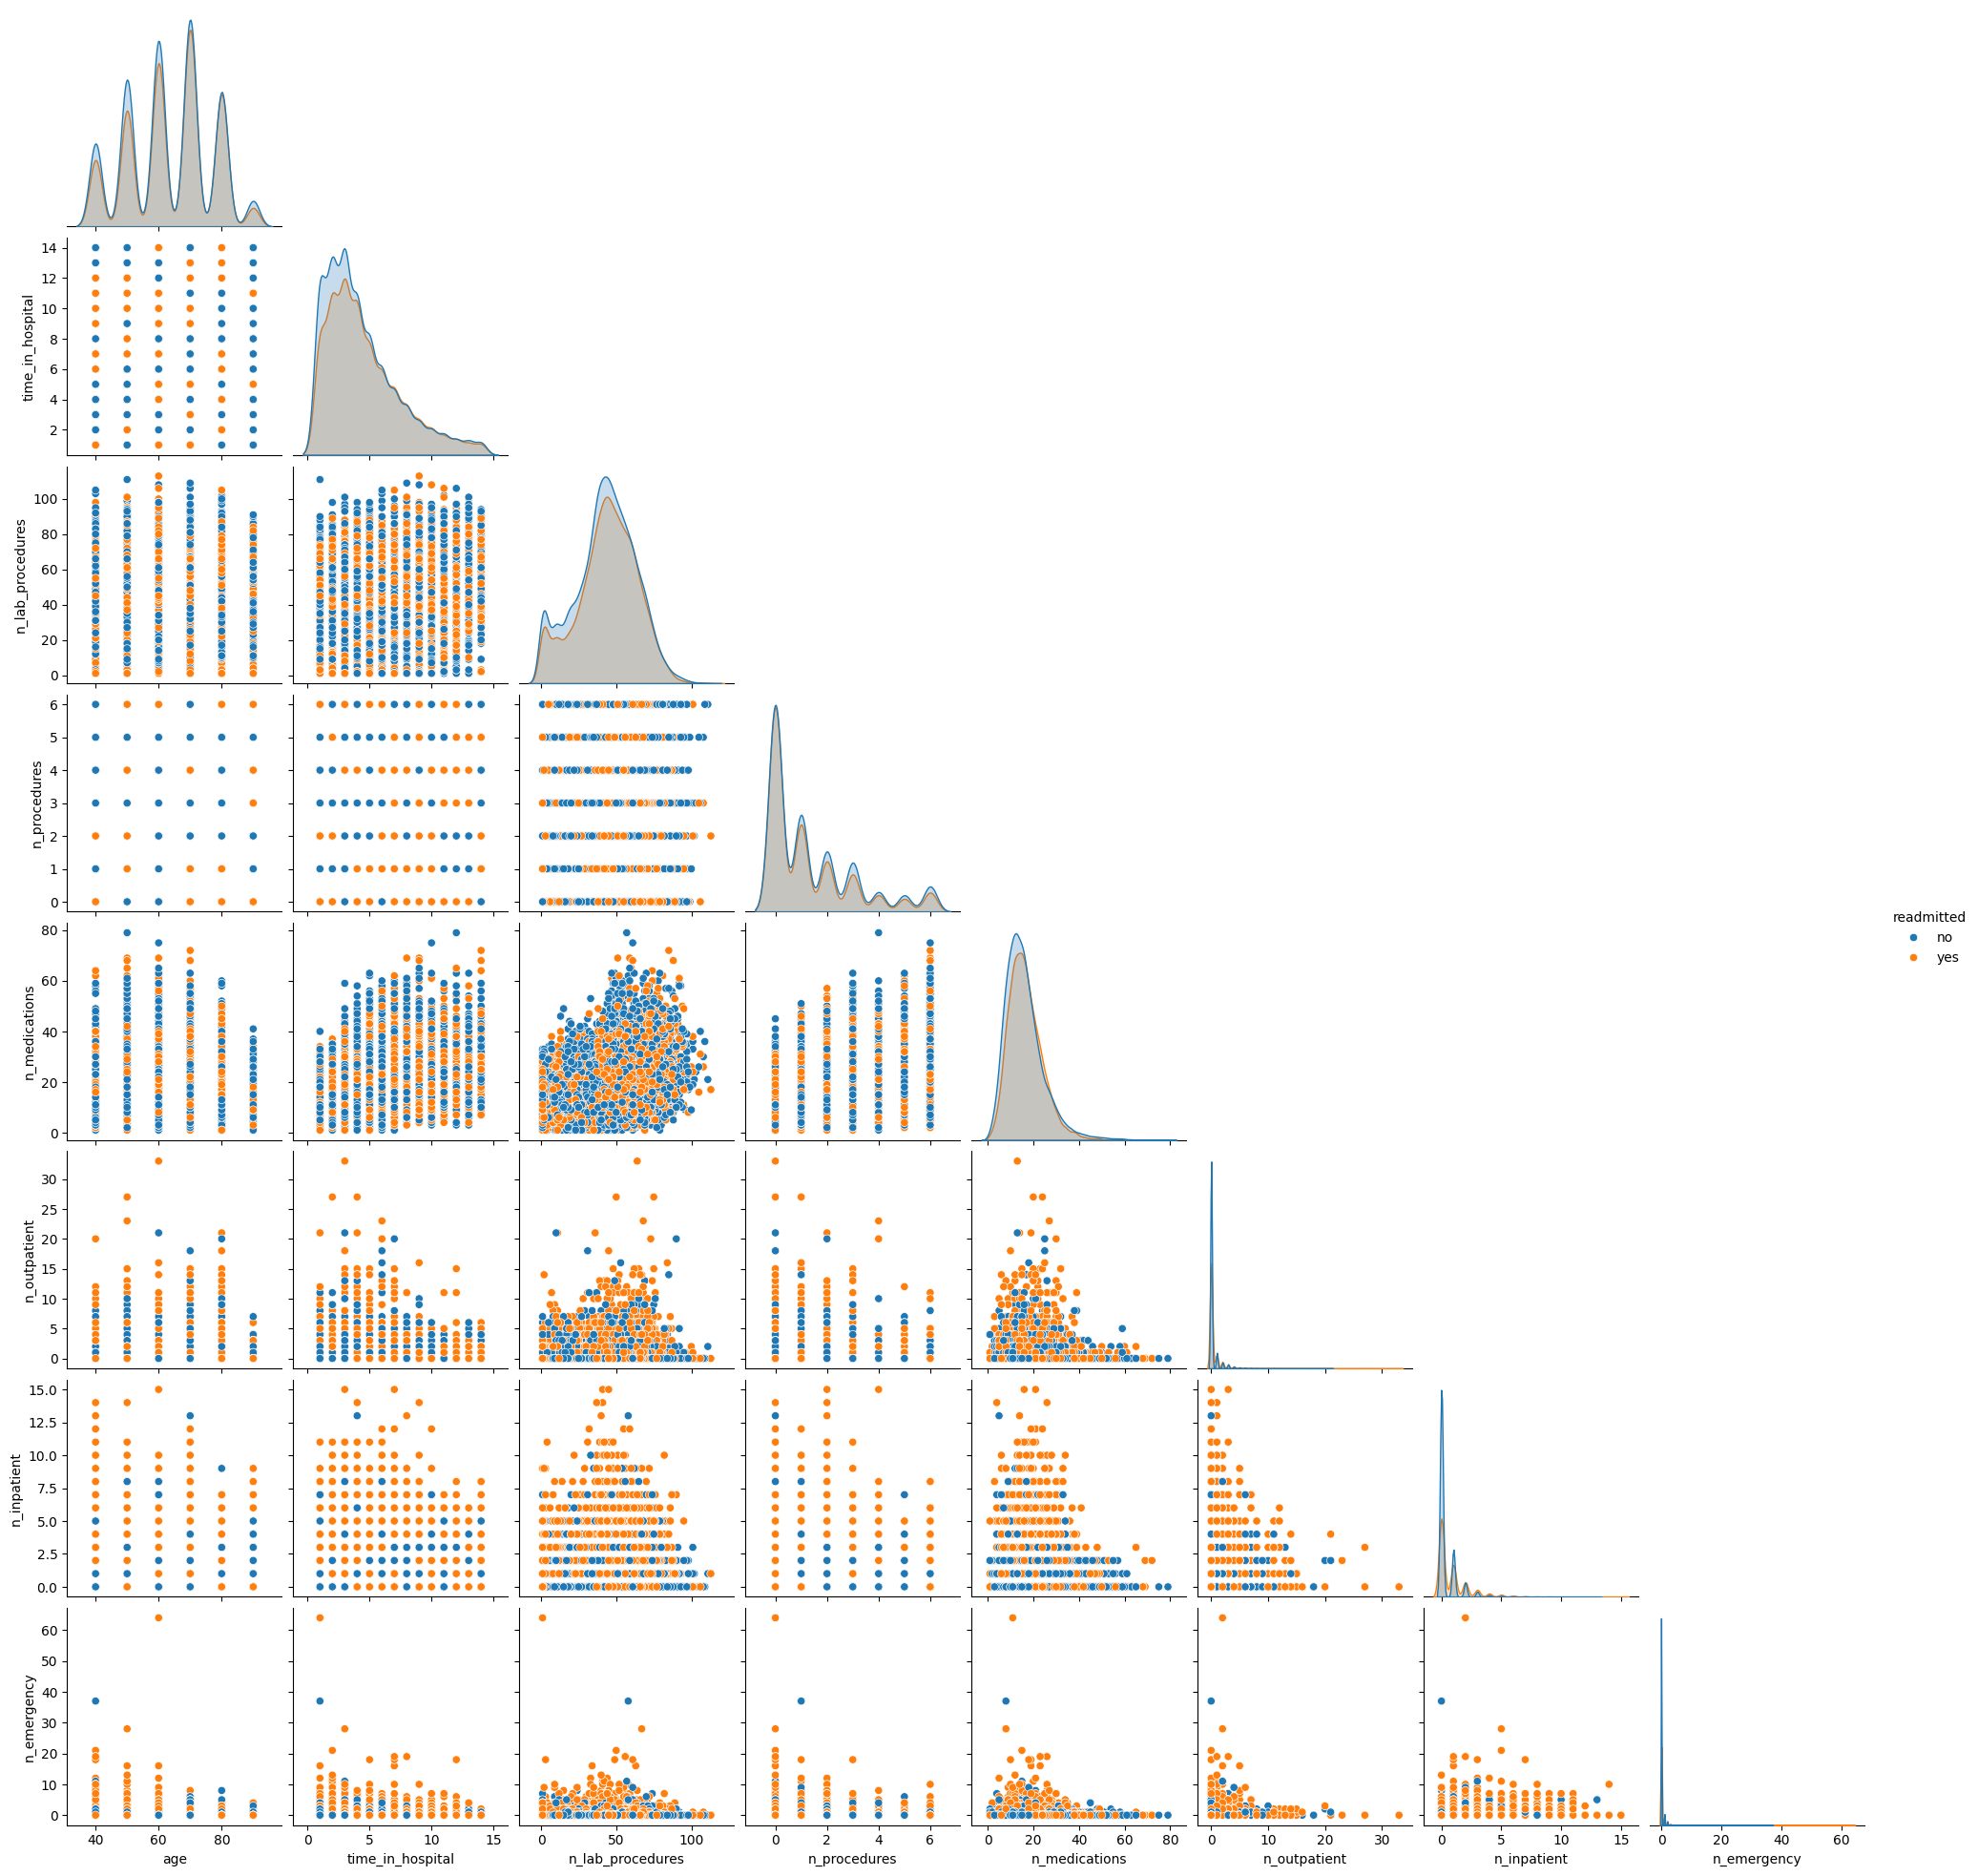

In [ ]:
numeric_cols = ['age', 'time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
sns.pairplot(df[numeric_cols + ['readmitted']], hue='readmitted', corner=True)
plt.show()

/tmp/ipython-input-1212635433.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='readmitted_rate', y=dept_risk.index, data=dept_risk, palette='mako')


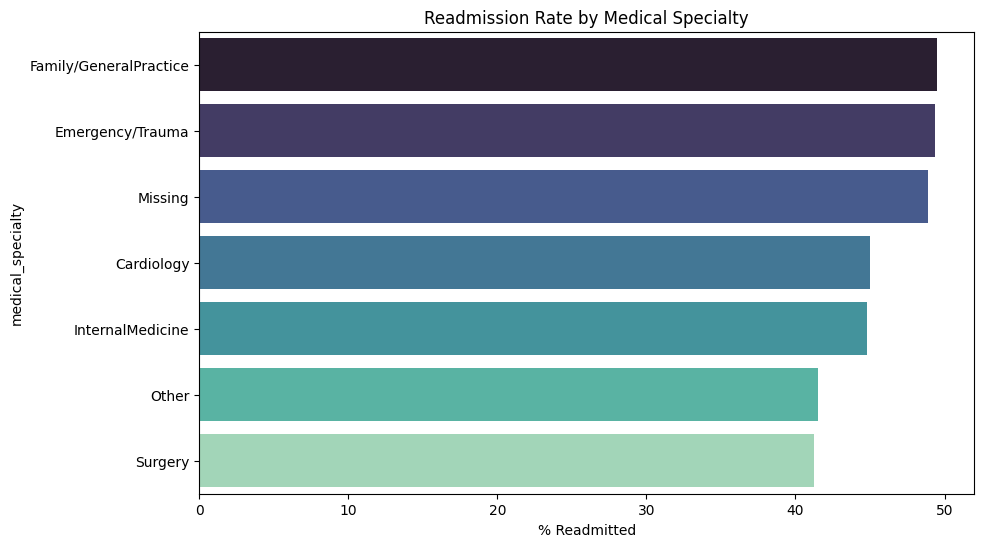

In [ ]:
dept_risk = df.groupby('medical_specialty')['readmitted'].value_counts(normalize=True).unstack()
dept_risk['readmitted_rate'] = dept_risk['yes']*100
dept_risk = dept_risk.sort_values('readmitted_rate', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='readmitted_rate', y=dept_risk.index, data=dept_risk, palette='mako')
plt.xlabel("% Readmitted")
plt.title("Readmission Rate by Medical Specialty")
plt.show()

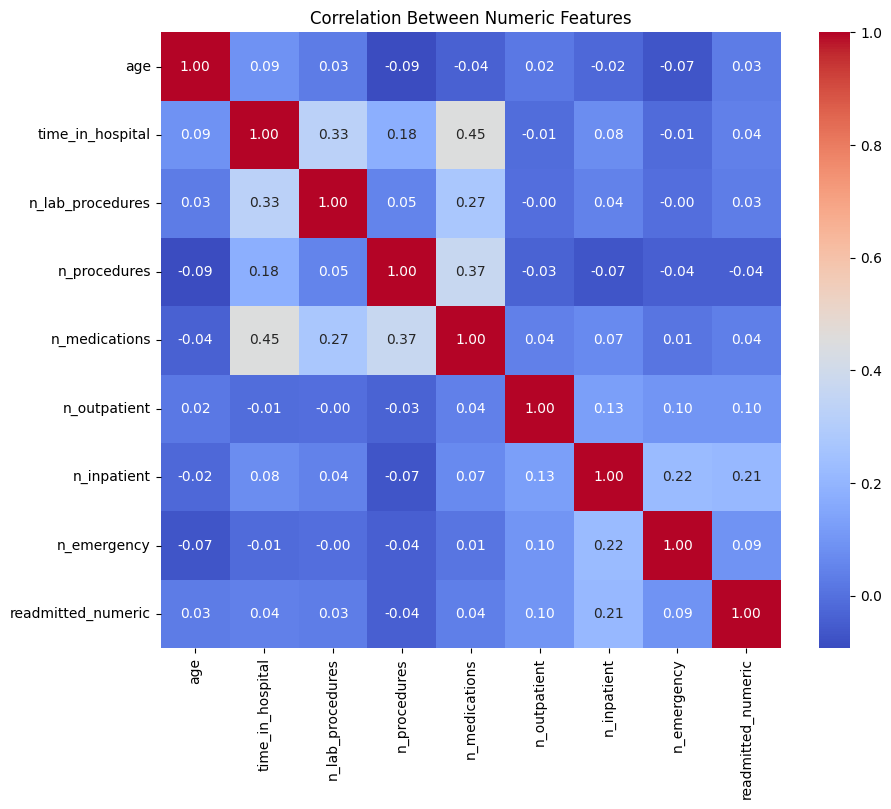

In [ ]:
numeric_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10,8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

/tmp/ipython-input-2582246851.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='readmitted', y='time_in_hospital', data=df, palette='Set2')


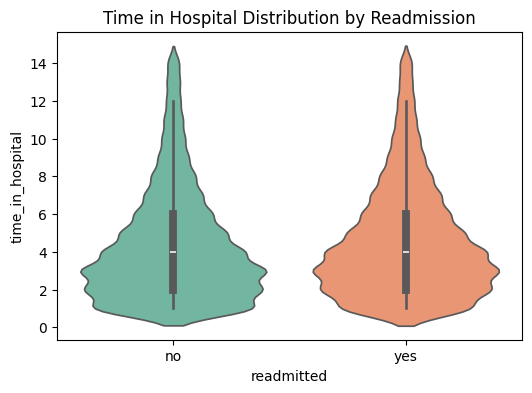

In [ ]:
plt.figure(figsize=(6,4))
sns.violinplot(x='readmitted', y='time_in_hospital', data=df, palette='Set2')
plt.title("Time in Hospital Distribution by Readmission")
plt.show()

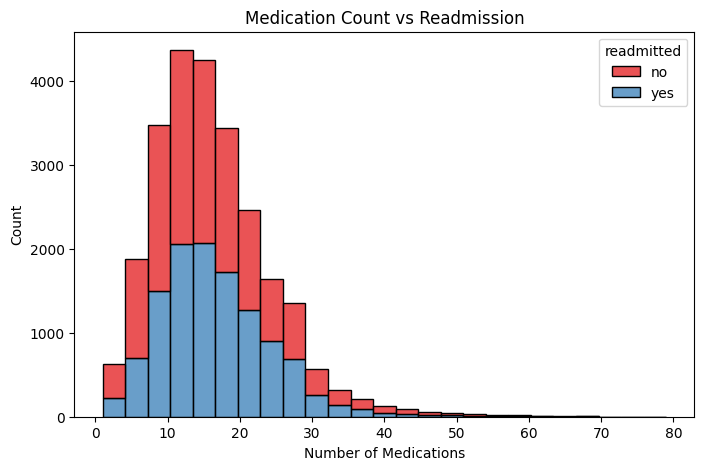

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(data=df, x='n_medications', hue='readmitted', multiple='stack', bins=25, palette='Set1')
plt.title("Medication Count vs Readmission")
plt.xlabel("Number of Medications")
plt.show()

Predictive Modeling

Confusion Matrix:
 [[1698  960]
 [1035 1307]]

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63      2658
           1       0.58      0.56      0.57      2342

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000


ROC-AUC Score: 0.6361292529071317


/tmp/ipython-input-3751034861.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:10], y=importances.index[:10], palette='viridis')


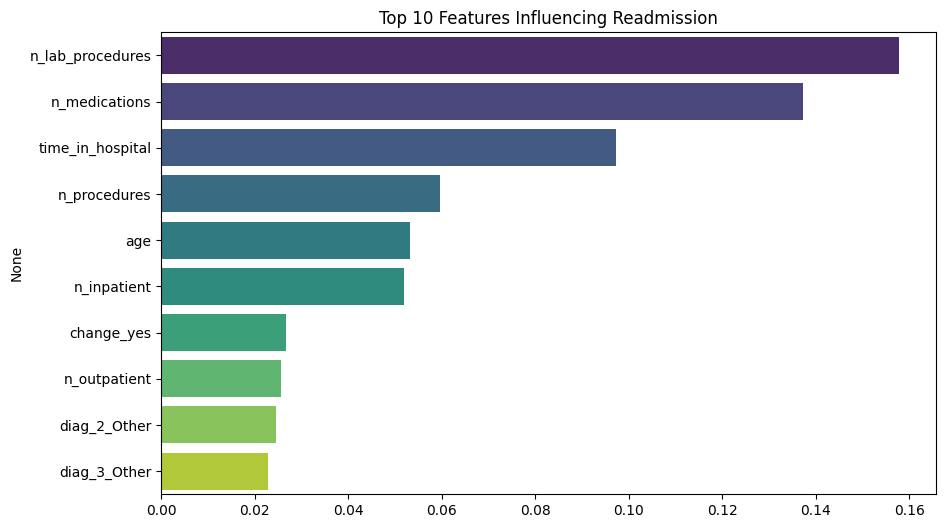

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt

# Copy dataset
df_model = df.copy()

# Convert target to numeric
df_model['readmitted_numeric'] = df_model['readmitted'].map({'no':0,'yes':1})

# One-hot encode categorical columns
categorical_cols = df_model.select_dtypes(include=['object','category']).columns
categorical_cols = [col for col in categorical_cols if col != 'readmitted']
df_model_encoded = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Features and target
X = df_model_encoded.drop(['readmitted','readmitted_numeric'], axis=1)
y = df_model_encoded['readmitted_numeric']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_res, y_train_res)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Feature Importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances.values[:10], y=importances.index[:10], palette='viridis')
plt.title("Top 10 Features Influencing Readmission")
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# -----------------------------
# Function to predict readmission
# -----------------------------
def predict_readmission(new_patient_data, model, feature_columns):
    """
    Predict readmission for a new patient.

    Parameters:
    - new_patient_data: dict of patient features (numeric & categorical encoded)
    - model: trained Random Forest model
    - feature_columns: list of columns used in training

    Returns:
    - Prediction ('Yes'/'No') and probability of readmission
    """

    patient_df = pd.DataFrame([new_patient_data])

    # Ensure all training columns exist
    for col in feature_columns:
        if col not in patient_df.columns:
            patient_df[col] = 0

    # Reorder columns
    patient_df = patient_df[feature_columns]

    # Predict
    pred_label = model.predict(patient_df)[0]
    pred_prob = model.predict_proba(patient_df)[0][1]

    return ('Yes' if pred_label==1 else 'No', pred_prob)

# -----------------------------
# Interactive user input
# -----------------------------
print("Enter new patient details to predict readmission:")

age = int(input("Age: "))
time_in_hospital = int(input("Time in hospital (days): "))
n_lab_procedures = int(input("Number of lab procedures: "))
n_procedures = int(input("Number of procedures: "))
n_medications = int(input("Number of medications: "))
n_outpatient = int(input("Number of outpatient visits: "))
n_inpatient = int(input("Number of inpatient visits: "))
n_emergency = int(input("Number of emergency visits: "))

# Simple age group encoding
age_group_36_60 = 1 if 36 <= age <= 60 else 0
age_group_60_plus = 1 if age > 60 else 0

# Example for categorical features (adjust according to your dataset)
medical_specialty_InternalMedicine = int(input("Medical specialty InternalMedicine? (1=Yes,0=No): "))
medical_specialty_Missing = int(input("Medical specialty Missing? (1=Yes,0=No): "))
diag_1_Circulatory = int(input("Primary diagnosis Circulatory? (1=Yes,0=No): "))
diag_1_Other = int(input("Primary diagnosis Other? (1=Yes,0=No): "))
diag_2_Respiratory = int(input("Secondary diagnosis Respiratory? (1=Yes,0=No): "))
diag_2_Circulatory = int(input("Secondary diagnosis Circulatory? (1=Yes,0=No): "))
diag_3_Other = int(input("Tertiary diagnosis Other? (1=Yes,0=No): "))
diag_3_Diabetes = int(input("Tertiary diagnosis Diabetes? (1=Yes,0=No): "))
glucose_test_yes = int(input("Glucose test done? (1=Yes,0=No): "))
a1ctest_yes = int(input("A1C test done? (1=Yes,0=No): "))
change_yes = int(input("Change in medications? (1=Yes,0=No): "))
diabetes_med_yes = int(input("Diabetes medication? (1=Yes,0=No): "))

# Create patient dict
new_patient = {
    'age': age,
    'time_in_hospital': time_in_hospital,
    'n_lab_procedures': n_lab_procedures,
    'n_procedures': n_procedures,
    'n_medications': n_medications,
    'n_outpatient': n_outpatient,
    'n_inpatient': n_inpatient,
    'n_emergency': n_emergency,
    'age_group_36-60': age_group_36_60,
    'age_group_60+': age_group_60_plus,
    'medical_specialty_InternalMedicine': medical_specialty_InternalMedicine,
    'medical_specialty_Missing': medical_specialty_Missing,
    'diag_1_Circulatory': diag_1_Circulatory,
    'diag_1_Other': diag_1_Other,
    'diag_2_Respiratory': diag_2_Respiratory,
    'diag_2_Circulatory': diag_2_Circulatory,
    'diag_3_Other': diag_3_Other,
    'diag_3_Diabetes': diag_3_Diabetes,
    'glucose_test_yes': glucose_test_yes,
    'a1ctest_yes': a1ctest_yes,
    'change_yes': change_yes,
    'diabetes_med_yes': diabetes_med_yes
}

# -----------------------------
# Predict
# -----------------------------
prediction, probability = predict_readmission(new_patient, rf, X_train.columns)
print("\nPredicted Readmission:", prediction)
print("Probability of Readmission:", round(probability, 2))


Enter new patient details to predict readmission:
Age: 70
Time in hospital (days): 5
Number of lab procedures: 40
Number of procedures: 1
Number of medications: 15
Number of outpatient visits: 0
Number of inpatient visits: 0
Number of emergency visits: 0
Medical specialty InternalMedicine? (1=Yes,0=No): 1
Medical specialty Missing? (1=Yes,0=No): 0
Primary diagnosis Circulatory? (1=Yes,0=No): 1
Primary diagnosis Other? (1=Yes,0=No): 0
Secondary diagnosis Respiratory? (1=Yes,0=No): 1
Secondary diagnosis Circulatory? (1=Yes,0=No): 0
Tertiary diagnosis Other? (1=Yes,0=No): 1
Tertiary diagnosis Diabetes? (1=Yes,0=No): 0
Glucose test done? (1=Yes,0=No): 0
A1C test done? (1=Yes,0=No): 1
Change in medications? (1=Yes,0=No): 0
Diabetes medication? (1=Yes,0=No): 1

Predicted Readmission: Yes
Probability of Readmission: 0.53
